# Cell 1: Imports & Data Cleaning Functions

This cell imports the required libraries and defines two key functions:
- `clean_numeric` cleans numeric fields by removing unwanted characters.
- `clean_and_process` loads each CSV file, standardizes column names, cleans price columns, drops duplicates and rows missing an essential "item_price", calculates discount percentages if available, and adds a day identifier.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

def clean_numeric(val):
    """Remove commas, currency symbols, and non-numeric characters from a value."""
    if pd.isna(val):
        return val
    # Remove commas and unwanted characters (keep digits, dot, and minus sign)
    val_str = str(val).replace(',', '')
    return re.sub(r'[^\d\.\-]', '', val_str)

def clean_and_process(file_path, day_tag):
    """
    Load a CSV file, clean its columns, drop duplicate rows and rows missing 'item_price',
    convert price columns to numeric, compute discount percentages if applicable,
    and add a day identifier.
    """
    # Load CSV file
    df = pd.read_csv(file_path)
    
    # Drop irrelevant columns
    cols_to_drop = ['Special Text', 'Complex Promo Text', 'Link']
    df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
    
    # Standardize column names: trim, lower-case, and replace spaces with underscores.
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    
    # Define price columns to clean and convert
    price_cols = ['best_price', 'best_unit_price', 'item_price', 'unit_price', 'price_was']
    for col in price_cols:
        if col in df.columns:
            df[col] = df[col].apply(clean_numeric)
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Remove duplicate rows
    df.drop_duplicates(inplace=True)
    
    # Drop rows where the essential 'item_price' is missing
    df.dropna(subset=['item_price'], inplace=True)
    
    # Compute discount percentage if 'price_was' is available (avoid division by zero)
    if 'price_was' in df.columns:
        df['price_was'] = df['price_was'].replace(0, pd.NA)
        df['discount_percentage'] = ((df['price_was'] - df['item_price']) / df['price_was']) * 100
    
    # Add a column to indicate the day of data collection
    df['day'] = day_tag
    
    return df

# Quick test with Tuesday data
tue_df_test = clean_and_process("Tue10SepWoolworths 1(in).csv", "Tuesday")
print("Processed Tuesday file columns:", tue_df_test.columns.tolist())
print("Number of records (Tuesday):", len(tue_df_test))


Processed Tuesday file columns: ['product_code', 'category', 'item_name', 'best_price', 'best_unit_price', 'item_price', 'unit_price', 'price_was', 'discount_percentage', 'day']
Number of records (Tuesday): 24722


# Cell 2: Loading, Cleaning & Combining All Files

This cell uses the cleaning function from Cell 1 to load and clean all three CSV files corresponding to Tuesday, Wednesday, and Sunday. Each file gets a day identifier before they are combined into a single DataFrame. The combined data is then saved as "Combined_Cleaned.csv".


In [2]:
# Define file paths and corresponding day labels.
files = [
    ("Tue10SepWoolworths 1(in).csv", "Tuesday"),
    ("Wed04SepWoolworths 1(in).csv", "Wednesday"),
    ("Sun4AugWoolworths 1(in).csv", "Sunday")
]

# Process each file and store the cleaned DataFrames.
cleaned_dfs = []
for file_path, day in files:
    df_clean = clean_and_process(file_path, day)
    print(f"Processed file for {day}: {len(df_clean)} records")
    cleaned_dfs.append(df_clean)

# Combine all DataFrames into one
combined_df = pd.concat(cleaned_dfs, ignore_index=True)
print("Combined data shape:", combined_df.shape)

# Save the combined data for Power BI ingestion.
combined_df.to_csv("Combined_Cleaned.csv", index=False)
print("Combined cleaned data saved as 'Combined_Cleaned.csv'")


Processed file for Tuesday: 24722 records
Processed file for Wednesday: 24778 records
Processed file for Sunday: 22365 records
Combined data shape: (71865, 10)
Combined cleaned data saved as 'Combined_Cleaned.csv'


# Cell 3: Unit Detection & Converting 10g/100g to Kg

This cell detects the measurement unit from product names. It now checks for both "100g" and "10g":
- If a product is sold in 100g portions, its `unit_price` is converted to a per‑kg basis by multiplying by 10.
- If a product is sold in 10g portions, its `unit_price` is converted to a per‑kg basis by multiplying by 100.
- Other unit types (e.g. "kg" or "each") are left unchanged.
This ensures that all unit prices reflect a price per kilogram.


In [3]:
import re
import pandas as pd

def convert_unit_price(row):
    """
    Checks the product name for a weight measurement.
    
    If found:
      - For kilograms (kg), divides the unit price by the weight to obtain the per‑kg price.
      - For grams (g), multiplies the unit price by (1000 / weight) to convert to per‑kg.
      
    If no weight measurement is found, it returns the original unit price and flags the product as "each".
    
    Returns a Series with the converted unit_price and a measurement type ("kg" or "each").
    """
    product_name = str(row['item_name'])
    price = row['unit_price']
    
    # Return original price if it's missing.
    if pd.isna(price):
        return pd.Series([price, "each"])
    
    # Search for a weight measurement in the product name (e.g., "250g", "1kg")
    match = re.search(r'(\d+(?:\.\d+)?)\s*(kg|g)', product_name.lower())
    
    if match:
        weight_val = float(match.group(1))
        unit_found = match.group(2)
        if unit_found == 'kg':
            # Price is for weight_val kg, so price per kg:
            converted_price = price / weight_val
            return pd.Series([converted_price, "kg"])
        elif unit_found == 'g':
            # Price is for weight_val g, so price per kg:
            converted_price = price * (1000 / weight_val)
            return pd.Series([converted_price, "kg"])
    else:
        # No weight measurement detected: treat it as sold "each"
        return pd.Series([price, "each"])

# Assume combined_df is already loaded / combined from earlier steps.
# Apply conversion across the DataFrame.
converted = combined_df.apply(convert_unit_price, axis=1)
combined_df['unit_price'] = converted[0]
combined_df['measurement_type'] = converted[1]

print("Measurement type counts after conversion:")
print(combined_df['measurement_type'].value_counts())

# Optionally, save the updated DataFrame
combined_df.to_csv("Combined_Cleaned_Converted.csv", index=False)
print("Converted data saved as 'Combined_Cleaned_Converted.csv'")


Measurement type counts after conversion:
measurement_type
each    39222
kg      32643
Name: count, dtype: int64
Converted data saved as 'Combined_Cleaned_Converted.csv'


C:\Users\eugen\AppData\Local\Temp\ipykernel_38604\1053180928.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="day", y="item_price", data=avg_item_price_by_day, palette="Set2")


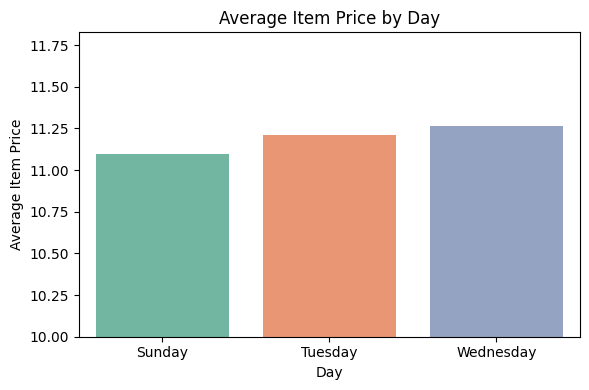

C:\Users\eugen\AppData\Local\Temp\ipykernel_38604\1053180928.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="day", y="discount_count", data=discount_counts, palette="Set1")


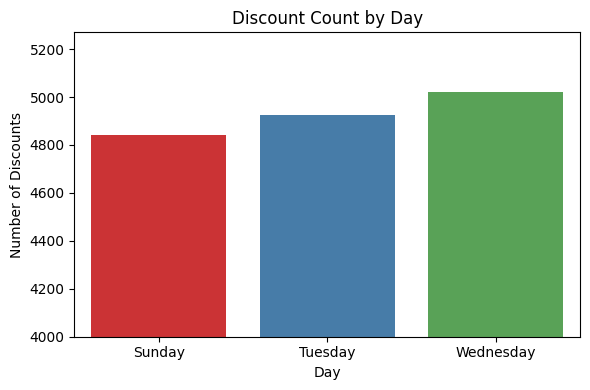

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the combined dataset
combined_df = pd.read_csv("Combined_Cleaned_Converted.csv")

# Visualization 1: Average Item Price by Day with truncated y-axis
avg_item_price_by_day = combined_df.groupby("day")["item_price"].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x="day", y="item_price", data=avg_item_price_by_day, palette="Set2")
plt.title("Average Item Price by Day")
# Set the y-axis lower bound (adjust based on your data's range)
plt.ylim(10, None)
plt.xlabel("Day")
plt.ylabel("Average Item Price")
plt.tight_layout()
plt.show()

# Visualization 2: Discount Count by Day with truncated y-axis
discount_counts = (combined_df[combined_df["discount_percentage"] > 0]
                   .groupby("day")
                   .size()
                   .reset_index(name="discount_count"))

plt.figure(figsize=(6,4))
sns.barplot(x="day", y="discount_count", data=discount_counts, palette="Set1")
plt.title("Discount Count by Day")
# Set the y-axis lower bound (adjust based on your data's range)
plt.ylim(4000, None)
plt.xlabel("Day")
plt.ylabel("Number of Discounts")
plt.tight_layout()
plt.show()
